In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


## Data analysis and preprocessing

In [15]:
diamonds_df = pd.read_csv('datasets\diamonds\diamonds.csv')
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [26]:
diamonds_df.info()
# There are 9 features, 3 categorical (cut, color and clarity) and 6 numerical (float64). The targe variable, price, is int64.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB


In [27]:
diamonds_df.isna().sum()
#There are no missing values

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

#### Statistical analysis

In [28]:
diamonds_df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


Some interesting insigths for the numerical values:
* comparing the mean of each feature, they have very different scale, so they should be scaled to the same range
* x, y and z have min=0, which means there's one or more outliers that should be removed since this are physical quantities and must be >0 
* price has min=-1, which also indicates the presence of outliers since the price must be >0

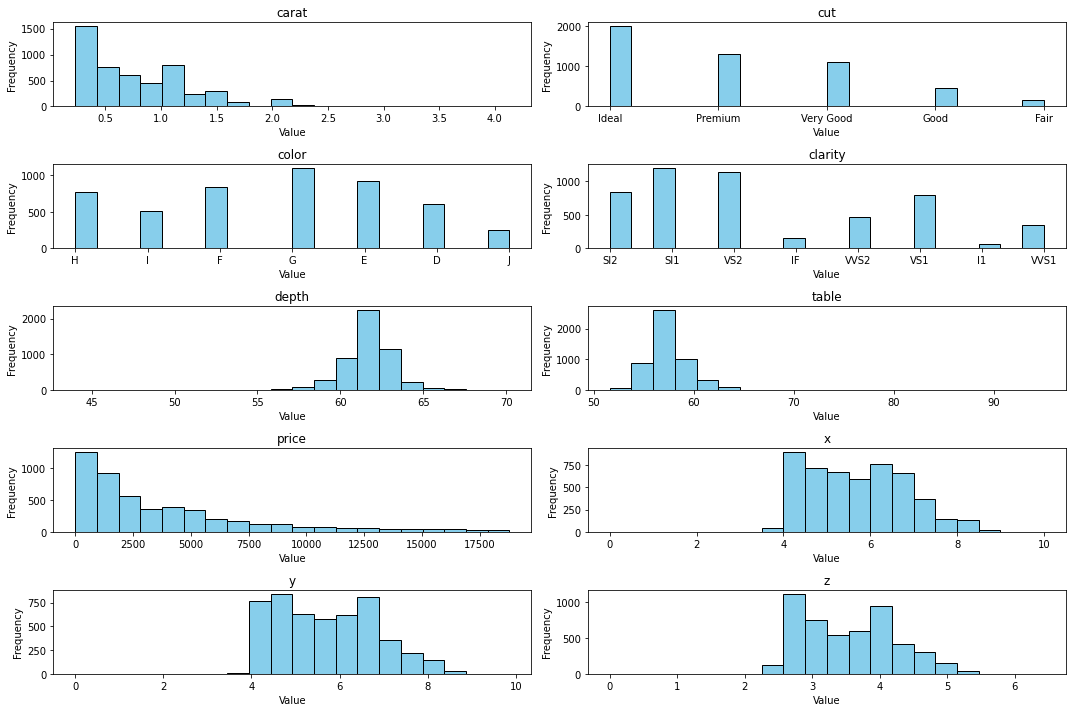

In [29]:
#Plot the distribution of each variable
import matplotlib.pyplot as plt

def plot_distribution(df):
    columns = df.columns
    
    num_rows = len(columns) // 2
    num_cols = 2 if len(columns) % 2 == 0 else 3
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    
    if num_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_distribution(diamonds_df)

Some variables appear to be normally distributed, while others are clearly not. 

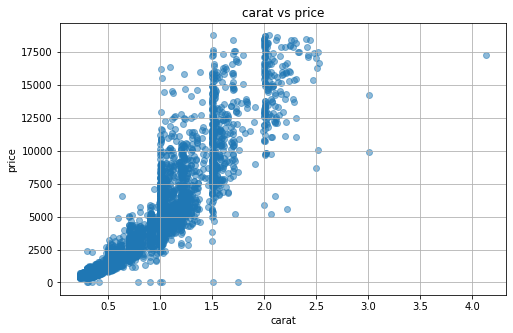

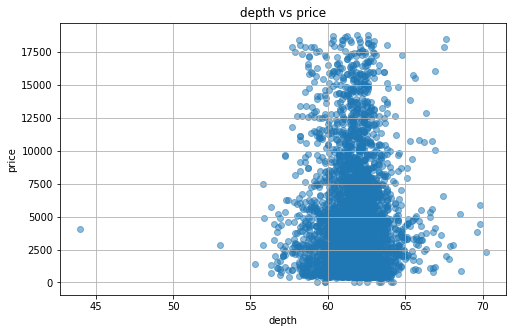

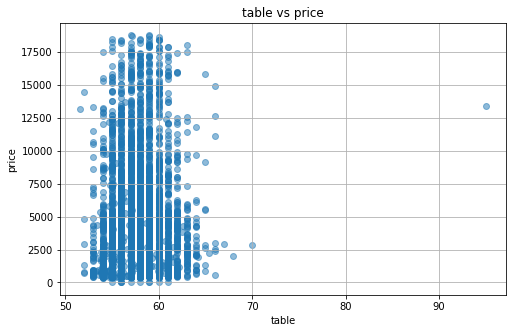

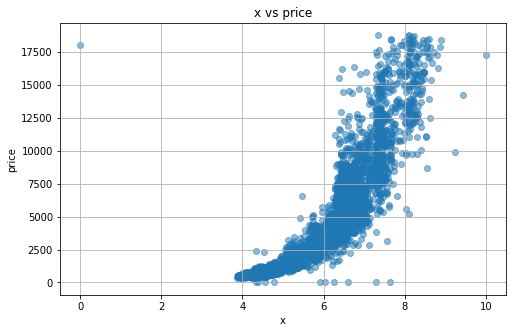

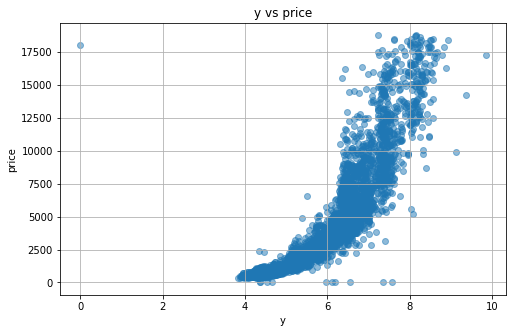

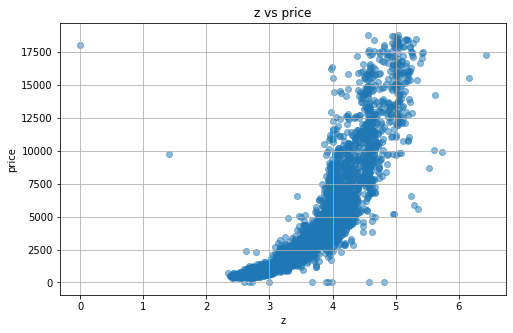

In [5]:
target_column = 'price'

#Exclude categorical features as a scatterplot wouldn't be a good choice
cat_cols = ['cut', 'color','clarity']

feature_columns = [col for col in diamonds_df.columns if col != target_column and col not in cat_cols]

for feature in feature_columns:
    plt.figure(figsize=(8, 5))
    plt.scatter(diamonds_df[feature], diamonds_df[target_column], alpha=0.5)
    plt.title(f'{feature} vs {target_column}')
    plt.xlabel(feature)
    plt.ylabel(target_column)
    plt.grid(True)
    plt.show()

This kind of scatterplots are more useful for numerical variables. For the categorical, the histograms plotted above are better.  
Insights:
* x, y, z do not seem linearly related to the price
* both depth and table don't show much relationship with price

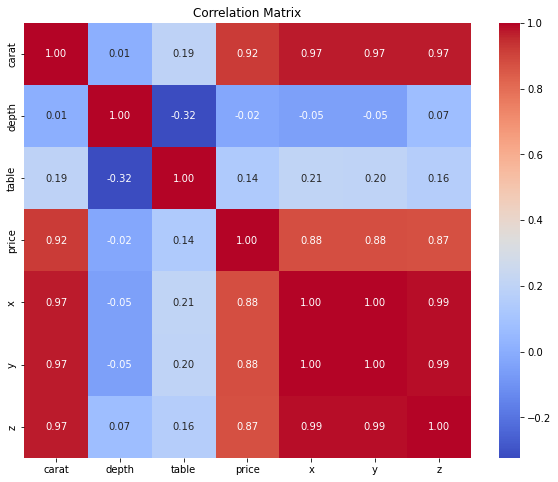

In [7]:
#Calculate correlation between features

correlation_matrix = diamonds_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


We see some cases of highly correlated variables: x, y, z and carat. This is a problem for linear regression, as it's not possible to asses the independent effect of each variable on the price.

#### Handling outliers
In the previous plots, there are points that appear to be outliers. For example, the point with x=0, y=0, z=0 is crearly a mistake and should be removed. Also the points with price=-1, which don't provide any useful information.

In [8]:
diamonds_df[diamonds_df['z'] == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


In [16]:
diamonds_df[diamonds_df['price'] < 0]

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [17]:
diamonds_df = diamonds_df[diamonds_df['price'] > 0]
diamonds_df = diamonds_df[diamonds_df['z'] > 0]
diamonds_df.reset_index(drop=True, inplace=True)

#### Handling categorical data
The categorical variables are cut, color and clarity. The three of them are ordinal, meaning that there's an order between variables. For example, for 'cut', 'Good' > 'Fair', and 'Premium' >> 'Fair'. The same applies to 'color' and 'clarity' (judging from the reference images provided in _md-images). So we can use ordinal encoding, which assigns a numeric value to each variable.
If there was no relationship between classes (for example, in a variable 'country'), one-hot encoding should be used instead, but this come with the disadvantage of increasing the dimensionality of the data.  

In [7]:
print(diamonds_df['cut'].unique())
print(diamonds_df['color'].unique())
print(diamonds_df['clarity'].unique())

['Ideal' 'Premium' 'Very Good' 'Good' 'Fair']
['H' 'I' 'F' 'G' 'E' 'D' 'J']
['SI2' 'SI1' 'VS2' 'IF' 'VVS2' 'VS1' 'I1' 'VVS1']


In [18]:
#Define category order for each feature
cut_order = [['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']]
color_order = [['D','E','F','G','H','I','J']]
clarity_order = [['IF','VVS1', 'VVS2','VS1','VS2','SI1','SI2','I1']]

In [19]:
cut_encoder  = OrdinalEncoder(categories=cut_order)
color_encoder  = OrdinalEncoder(categories=color_order)
clarity_encoder  = OrdinalEncoder(categories=clarity_order)
diamonds_df['cut']  = cut_encoder.fit_transform(diamonds_df['cut'].values.reshape(-1, 1))
diamonds_df['color']  = color_encoder.fit_transform(diamonds_df['color'].values.reshape(-1, 1))
diamonds_df['clarity']  = clarity_encoder.fit_transform(diamonds_df['clarity'].values.reshape(-1, 1))


In [20]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,0.0,4.0,6.0,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,0.0,4.0,5.0,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,1.0,5.0,5.0,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,0.0,2.0,5.0,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,2.0,2.0,4.0,61.7,57.0,4493,6.17,6.21,3.82


#### Data scaling
min-max scaling is more sensitive to outliers, so I chose z-score scaling instead, which transforms each feature to have mean=0 and std=1

In [22]:
columns_to_scale = diamonds_df.columns[diamonds_df.columns != 'price']

scaler = StandardScaler()

scaler.fit(diamonds_df[columns_to_scale])

scaled_data = scaler.transform(diamonds_df[columns_to_scale])

scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

scaled_df['price'] = diamonds_df['price']

In [23]:
scaled_df.describe()

,carat,cut,color,clarity,depth,table,x,y,z,price
count,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4.989000e+03,4989.000000
mean,7.450444e-17,2.646376e-16,2.447208e-16,3.936630e-16,-1.453805e-15,2.283206e-15,4.103530e-16,-1.202575e-16,1.243699e-15,3930.581880
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,3970.923311
min,-1.205548e+00,-9.798650e-01,-1.541922e+00,-2.415136e+00,-1.225310e+01,-2.587376e+00,-1.672033e+00,-1.703090e+00,-3.085091e+00,351.000000
25%,-8.422491e-01,-9.798650e-01,-9.505891e-01,-5.766060e-01,-4.917912e-01,-6.400643e-01,-9.194428e-01,-9.186387e-01,-9.205513e-01,942.000000
50%,-2.011331e-01,-8.860767e-02,2.320765e-01,3.623749e-02,6.168191e-02,-1.974935e-01,-3.246146e-02,-2.598734e-02,-5.343205e-03,2398.000000
75%,5.254649e-01,8.026497e-01,8.234093e-01,6.490810e-01,5.459709e-01,6.876480e-01,7.290881e-01,7.314138e-01,7.210124e-01,5376.000000
max,7.128959e+00,2.585164e+00,2.006075e+00,1.874768e+00,5.873150e+00,1.662020e+01,3.829043e+00,3.715935e+00,4.207519e+00,18787.000000


#### Data splitting
Split the data into a train and a test set

In [138]:

X = scaled_df.drop(columns=['price'])  # Features
y = scaled_df['price']  # Target variable
test_prop = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=20)

In [67]:
X_train

,carat,cut,color,clarity,depth,table,x,y,z
1733,-1.034584,-0.088608,-0.359256,-2.415136,0.130866,0.245077,-1.224063,-1.207172,-1.196566
363,0.461353,-0.979865,0.232076,0.036237,-0.491791,-0.640064,0.657413,0.686330,0.604796
4204,-0.970472,-0.979865,0.823409,-2.415136,-0.630160,-0.640064,-1.044874,-1.062906,-1.109404
1188,-1.013213,-0.979865,1.414742,0.036237,0.338418,-0.197494,-1.170306,-1.207172,-1.152985
2757,-0.564432,-0.979865,-0.359256,-1.189449,0.338418,-1.525206,-0.480432,-0.458788,-0.426629
...,...,...,...,...,...,...,...,...,...
1607,0.439983,-0.088608,0.823409,0.649081,-1.875474,1.130219,0.711169,0.749447,0.474052
3915,0.461353,-0.088608,0.232076,0.036237,-1.737106,0.687648,0.773885,0.713380,0.503106
1428,0.504094,-0.088608,1.414742,0.649081,-0.076686,0.687648,0.657413,0.686330,0.662904
4367,1.529880,-0.979865,-0.359256,0.649081,0.407603,-0.197494,1.436881,1.416682,1.490949


## Model selection
Considering the context of the problem, the chosen model should perform regression (as the targe variable 'price' is numerical) and should be interpretable (because the clients want to know how the price is calculated). A first try would be a non-parametric model, such as regression trees, which don't make any assumptions on the distribution of the input data. Then a linear regression can be tried, but before we need to check if the data fullfils the linear regression assumptions.

#### Regression tree
This algorithm doesn't make any assumptions regarding the input data distribution, and is still very interpretable.

In [44]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error

In [64]:
# Initialize the DecisionTreeRegressor
tree_reg = DecisionTreeRegressor() 

# Train the model using all columns
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

Let's evaluate the model using k-fold cross validation and compare it to test set performance, to identify if it's overfitting the data. I chose mean_absolute_error as comparison metric as it's more interpretable and more robust to outliers than mean_squared_error

In [65]:
from sklearn.model_selection import cross_val_score

cv_maes = cross_val_score(tree_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_maes = -cv_maes

#We need to aggregate the performance score for each fold into one metric
cv_mean_mae = cv_maes.mean()

print("Mean CV MAE:", cv_mean_mae)

#Now calculate performance on test set. NOTE that we use the model trained with the whole train data, in contrast to k-fold cross validation
y_pred_test = tree_reg.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test set MAE: ", mae_test)

Mean CV MAE: 472.43104193525124
Test set MAE:  485.93987975951904


We see that the model performs slightly better on train data, as expected, but the performance is similar in both sets, so it doesn't seem to be overfitted (low variance). But to determine if the error can be considered high or low (that is, the model bias), and thus whether the model is underfitted or not, we should analyze the target data distribution.

In [72]:
print(y_train.describe())
print(mae_test/y_train.mean())

count     3991.000000
mean      3929.921574
std       3960.713120
min        351.000000
25%        945.000000
50%       2396.000000
75%       5422.500000
max      18787.000000
Name: price, dtype: float64
0.12365129193194964


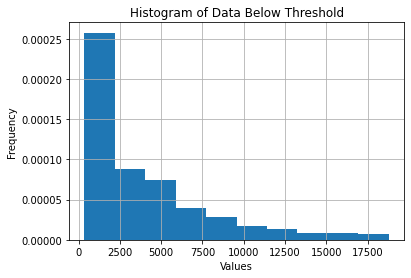

In [77]:
plt.hist(y_train,density=True)
plt.title('Histogram of Data Below Threshold')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We see that test MAE is about 12% of y_train mean, even though it's still higher than some of the lower values. It can be considered a decent result, although with some hyperparameter tuning it should improve even further. However, it depends on the bussiness requirement and how much error is acceptable for the final predicted price.

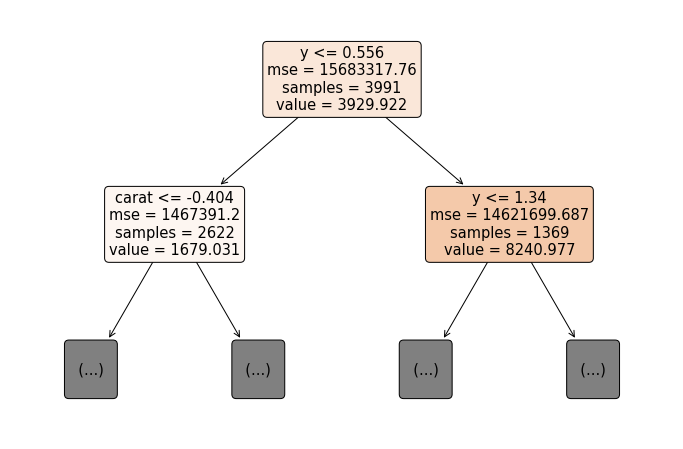

In [45]:
#The clients want to know the price is decided, so let's plot the tree. Only a few levels to keep it interpretable
plt.figure(figsize=(12, 8))
plot_tree(tree_reg, max_depth = 1,feature_names=X.columns, filled=True, rounded=True)
plt.savefig('decision_tree.png')
plt.show()



In [46]:
#Save tree graph to an image
plt.savefig('decision_tree.png')

<Figure size 432x288 with 0 Axes>

In [48]:
#From the graph, we see that the most important feature for this model is 'y'.
#We can in fact get the features ordered by their importance for the model

feature_importances = tree_reg.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names = [feature[0] for feature in sorted_feature_importance]

print("Features ordered by importance:")
for feature in sorted_feature_names:
    print(feature)


Features ordered by importance:
y
clarity
carat
color
x
z
depth
table
cut


##### Hyperparameter tuning
Let's try to improve model performance, using grid search hyperparameter tuning

In [78]:
from sklearn.model_selection import  GridSearchCV

In [105]:
# Define hyperparameters to tune
param_grid = {
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

In [106]:
regressor = DecisionTreeRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [107]:
#Once again, let's evaluate the model using k-fold CV, but this time with the optimized hyperparameters
cv_maes = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_maes = -cv_maes

#We need to aggregate the performance score for each fold into one metric
cv_mean_mae = cv_maes.mean()

print("Mean CV MAE:", cv_mean_mae)

#Now calculate performance on test set
y_pred_test = best_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test set MAE: ", mae_test)

Mean CV MAE: 432.43558291277185
Test set MAE:  468.7156491554538


Now performance is better on both sets than that of the previous, non-tuned model

#### Linear regression
This model makes 4 assumptions regarding the distribution of the input data:
* Linear relationship between each feature and the target variable
* Independence of residuals
* Homocedasticity
* Normality of the residuals


In [ ]:
#Pearson's coefficient to analize linearity

##### Feature selection

From the correlation matrix we see that x,y,z,carat are highly correlated, so it's not necessary to keep all of them as they encode similar information. 

From the scatterplots shown above, we see that x,y,z don't seem to have a linear relationship with price, but their Pearson coefficient is close to 1, so we shouldn't discard them.

In this scenario, we can use a feature selection algorithm, such a forward selection, using MAE as score to keep it coherent with the regression tree section.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

In [163]:
for n in range(1,9):
    linear_regression = LinearRegression()

    selector = SequentialFeatureSelector(linear_regression, n_features_to_select = n, direction='forward', scoring='neg_mean_absolute_error', cv=5)
    selector.fit(X_train, y_train)

    selected_feature_indices = selector.support_
    selected_features = X.columns[selected_feature_indices]
    print(n,selected_features)


    linear_regressor = LinearRegression()

    linear_regressor.fit(X_train[selected_features], y_train)

    cv_maes = cross_val_score(linear_regressor, X_train[selected_features], y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_maes = -cv_maes

    cv_mean_mae = cv_maes.mean()

    print(f"Mean CV MAE using {n} features:", cv_mean_mae)

    #Now calculate performance on test set
    y_pred_test = linear_regressor.predict(X_test[selected_features])
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print(f"Test set MAE {n} features: ", mae_test)

1 Index(['carat'], dtype='object')
Mean CV MAE using 1 features: 1010.8509066184818
Test set MAE 1 features:  1056.7725675865727


2 Index(['carat', 'x'], dtype='object')
Mean CV MAE using 2 features: 876.9835290467669
Test set MAE 2 features:  935.9117515292481
3 Index(['carat', 'clarity', 'x'], dtype='object')
Mean CV MAE using 3 features: 855.4068690936258
Test set MAE 3 features:  881.3830985710927
4 Index(['carat', 'color', 'clarity', 'x'], dtype='object')
Mean CV MAE using 4 features: 800.0966765363768
Test set MAE 4 features:  852.2410313114447
5 Index(['carat', 'cut', 'color', 'clarity', 'x'], dtype='object')
Mean CV MAE using 5 features: 786.334848595691
Test set MAE 5 features:  846.9332965115076
6 Index(['carat', 'cut', 'color', 'clarity', 'depth', 'x'], dtype='object')
Mean CV MAE using 6 features: 783.4383673418154
Test set MAE 6 features:  839.1298894360478
7 Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x'], dtype='object')
Mean CV MAE using 7 features: 781.7940356058999
Test set MAE 7 features:  840.3115330684483
8 Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'z

In [149]:
#Comparison using all features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

cv_maes = cross_val_score(linear_regressor, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_maes = -cv_maes

cv_mean_mae = cv_maes.mean()

print("Mean CV MAE:", cv_mean_mae)

#Now calculate performance on test set
y_pred_test = linear_regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test set MAE: ", mae_test)

Mean CV MAE: 782.7585112712258
Test set MAE:  840.216835603635


We could say that, in general, the model achieves better performance using more features, but this comes at the cost of increasing complexity.

# Conclusions

Even with the feature selection process, the linear regression has about twice the MAE of the regression tree, probably due to the lack of suitability of the input data for a linear regression model. So the regression tree, with the tuned hyperparameters, will be chose for deployment.